## Imports and paths

In [1]:
# ROOT PATH
# REPLACE root_path WITH CORRECT ROOT FOLDER PATH
root_path = "C:/Users/amira/OneDrive - University of Leeds/Projects/Palindrome/Market Segmentation/"

# path to code base
code_base_path = root_path + "Code/datafi_palindrome_segmentation/"

# path to root of raw data files
raw_data_path = root_path + "Data/"

# path to output folder
output_data_path = root_path + "Output Data - SA/"

In [2]:
### Import standard libraries
import os
# change working directory to the code base folder
os.chdir(path=code_base_path)

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Import bespoke functions from file (Palindrome Data)
from palindrome_functions import get_google_trends_data

In [3]:
## Choose Geographic Admin level for analysis to run over
# admin_level = "district" # or "region"

## Import Data

### 1. Import "UN district" and "SA facilities district" name matching
* this was manually created and matched. UNOCHA shapefiles and DHS survey use "UN district" naming.

In [4]:
district_names_df = pd.read_csv(
    output_data_path
    + "District Name Matching/"
    + "district_names_matched_UN_and_SA_facilities.csv"
)

# get district name replacement map
district_name_replace_map = dict(
    zip(
        district_names_df["UN_district_name"],
        district_names_df["SA_facilities_district_name"],
    )
)
# district_name_replace_map

### 2. Import DHS geographic summary stats tables

In [5]:
DHS_district_percentages = pd.read_excel(
    # root of data outputs
    output_data_path
    # specific subfolder
    + "Results/Final Summary Stats/"
    # filename
    "2 - district_weighted_stats.xlsx",
    sheet_name="district_%_all",
)

# match District names with SA Facilities dataset
DHS_district_percentages["district"] = DHS_district_percentages["district"].replace(district_name_replace_map)

# # check
# DHS_district_percentages.head()

In [6]:
DHS_district_target_info = pd.read_excel(
    # root of data outputs
    output_data_path
    # specific subfolder
    + "Results/Tables/Final Summary Stats/"
    # filename
    "OLD - district_segment_id_grouped_weighted_stats.xlsx",
    sheet_name="district_counts_target",
)

# match District names with SA Facilities dataset
DHS_district_target_info["district"] = DHS_district_target_info["district"].replace(district_name_replace_map)

# # check
# DHS_district_target_info.head()

In [7]:
# join together
DHS_info = pd.merge(
    DHS_district_target_info,
    DHS_district_percentages,
    on="district",
    suffixes=("_count", "_%"),
)
# set index to district and sort
DHS_info = DHS_info.set_index("district").sort_index()
# check
DHS_info.head()

n_total  %_of_total_ever_private  \
district                                                 
A Nzo DM               135.31                     0.65   
Amajuba DM             142.98                     0.83   
Amathole DM             55.38                     0.39   
Bojanala Platinum DM   372.49                     6.54   
Buffalo City MM        177.58                     2.03   

                      %_segment_ever_private  lower_ci  upper_ci  \
district                                                           
A Nzo DM                                8.23      3.60     12.86   
Amajuba DM                              9.95      5.04     14.85   
Amathole DM                            12.15      3.55     20.76   
Bojanala Platinum DM                   29.98     25.33     34.64   
Buffalo City MM                        19.55     13.71     25.38   

                      2_sigma_error  n_ever_private_no_count  \
district                                                       
A Nzo DM                       4.63                   124.17   
Amajuba DM                     4.91                   128.76   
Amathole DM                    8.61                    48.65   
Bojanala Platinum DM           4.65                   260.80   
Buffalo City MM                5.83                   142.87   

                      n_ever_private_yes_count  n_ever_private_no_%  \
district                                                              
A Nzo DM                                 11.14                91.77   
Amajuba DM                               14.22                90.05   
Amathole DM                               6.73                87.85   
Bojanala Platinum DM                    111.69                70.02   
Buffalo City MM                          34.71                80.45   

                      n_ever_private_yes_%  ...  know_place_hiv_test_yes  \
district                                    ...                            
A Nzo DM                              8.23  ...                    98.14   
Amajuba DM                            9.95  ...                    97.91   
Amathole DM                          12.15  ...                    96.97   
Bojanala Platinum DM                 29.98  ...                    99.43   
Buffalo City MM                      19.55  ...                   100.00   

                      heard_of_other_sti_yes  has_health_insurance_yes  \
district                                                                 
A Nzo DM                               69.77                      0.56   
Amajuba DM                             83.39                      1.11   
Amathole DM                            78.29                     15.16   
Bojanala Platinum DM                   88.97                     19.56   
Buffalo City MM                        92.30                     19.93   

                      hiv_result_negative  hiv_result_positive  \
district                                                         
A Nzo DM                            78.05                21.95   
Amajuba DM                          69.43                30.57   
Amathole DM                         70.59                29.41   
Bojanala Platinum DM                74.55                25.45   
Buffalo City MM                     87.77                12.23   

                      n_children_at_home_0.0  n_children_at_home_1.0  \
district                                                               
A Nzo DM                               49.16                   22.21   
Amajuba DM                             43.56                   21.92   
Amathole DM                            64.05                   17.81   
Bojanala Platinum DM                   51.74                   20.60   
Buffalo City MM                        53.63                   20.11   

                      n_children_at_home_2.0  n_children_at_home_3.0  \
district                                                               
A Nzo DM                   

### 3. Import SA facilities data

In [8]:
facilities_df_raw = pd.read_csv(
    raw_data_path
    + "SA Facility Types/"
    + "vwOrgunitStructureOU5.csv"
)

# select relevant variables
facilities_df = facilities_df_raw[
    [
        "OU2short",  # region
        "OU3short",  # district
        "OU5short",  # name of facility
        "OrgUnitOwnership",
        "OrgUnitRuralUrban",
        "OrgUnitType",  # info
        "coordinates",
        # 'lastupdated'
    ]
]

# rename
facilities_df.columns = [
    "region",
    "district",
    "facility_name",
    "ownership",
    "urban_rural",
    "facility_type",
    "coordinates_str"
    #'last_updated'
]

# check
facilities_df.head()
# facilities_df.count()
# facilities_df['facility_type'].unique()
# facilities_df['ownership'].unique()

region  district       facility_name     ownership urban_rural  \
0  Eastern Cape  A Nzo DM  Afsondering Clinic  Gov Province       Rural   
1  Eastern Cape  A Nzo DM      Bergview Pharm       Private       Urban   
2  Eastern Cape  A Nzo DM  Dr MD Liphapang GP       Private       Urban   
3  Eastern Cape  A Nzo DM  Elukholweni Clinic  Gov Province       Rural   
4  Eastern Cape  A Nzo DM   Isilindini Clinic  Gov Province       Rural   

          facility_type             coordinates_str  
0                Clinic   POINT(28.94812 -30.17988)  
1              Pharmacy  POINT(28.80539 -30.342847)  
2  General Practitioner                         NaN  
3                Clinic    POINT(28.84811 -30.6329)  
4                Clinic   POINT(28.59078 -30.62002)

### 4. Import shapefiles for mapping (UNOCHA)

<AxesSubplot:>

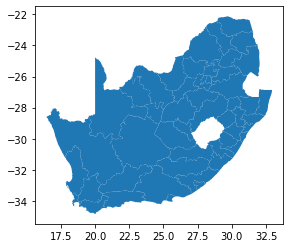

In [9]:
shapes_df = gpd.read_file(
    # root
    raw_data_path
    # extracted folder
    + "UNOCHA Subnational Administrative Boundaries/zaf_adm_sadb_ocha_20201109_shp/"
    # file: change following file to zaf_admbnda_adm1_sadb_ocha_20201109.dbf for level-1 admin area shapes (region)
    + "zaf_admbnda_adm2_sadb_ocha_20201109.dbf"
)

# only keep relevant columns
shapes_df = shapes_df[["ADM1_EN", "ADM2_EN", "geometry"]]
# rename columns
shapes_df = shapes_df.rename({"ADM1_EN": "region", "ADM2_EN": "district"}, axis=1)

# replace district names to match SA Facilities dataset (some new names too)
shapes_df["district"] = shapes_df["district"].replace(district_name_replace_map)
shapes_df = shapes_df.set_index("district").sort_index()

## Correct region name misspelling
shapes_df["region"].replace({"Nothern Cape": "Northern Cape"}, inplace=True)

# plot area shapes
shapes_df.plot()

## Merge datasets
District Shapes + Facilities Data + DHS vars and segments + Google Trends

### 1. District Shapes + Facilities Stats (Supply proxy)

##### Data prep: replace ownership with public and private

In [10]:
replace_map = {
    "ownership": {
        "Gov Province": "public",
        "Private": "private",
        "Gov Municipality": "public",
        "Gov DCS": "public",
        "Gov NHLS": "public",
        "Gov National": "public",
        "Not-for-profit": "public",
        "Gov Other": "public",
        "Gov SAMHS": "public",
        "Province Aided": "public",
        "E8 Programme": "public",
    }
}
facilities_df = facilities_df.replace(replace_map)

# check
facilities_df["ownership"].value_counts()

public     10222
private     6340
Name: ownership, dtype: int64

##### Get district summaries for private and public facility counts

In [11]:
def get_groupby_value_counts_df(df, value_count_var, groupby_var="region", prefix=""):
    """
    This function is essentially a customised cross-tabulation function.

    Args:
      df: the dataframe you want to use
      value_count_var: the variable that you want to count the values of
      groupby_var: the variable to group by. Defaults to region.
      prefix: the prefix to add to the column names.

    Returns:
      A dataframe with the counts of each value in the value_count_var for each value of the groupby_var.
    """

    # get grouped values
    df_reg = df.groupby(groupby_var)[value_count_var].value_counts().to_frame()
    df_reg.columns = ["count"]
    df_reg = df_reg.reset_index()

    # pivot to get correct dataframe shaoe
    df_reg = df_reg.pivot(groupby_var, value_count_var, "count").add_prefix(prefix)

    return df_reg

In [12]:
# Count the number of private and public facilities per admin level.
facilities_district_df = get_groupby_value_counts_df(
    facilities_df, 
    "ownership", 
    groupby_var="district", 
    prefix="facilities_"
)

# check
facilities_district_df.head(3)

ownership    facilities_private  facilities_public
district                                          
A Nzo DM                      6                128
Amajuba DM                   57                 81
Amathole DM                  14                249

#### Join datasets

In [13]:
# make sure all district names match
facilities_district_df.index == shapes_df.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [14]:
# join dataframes
geo_stats = shapes_df.join(facilities_district_df)

In [15]:
# get total n facilities and private ratio
geo_stats['total_facilities'] = geo_stats['facilities_public']+geo_stats['facilities_private']
geo_stats['%_private'] = geo_stats['facilities_private']/geo_stats['total_facilities']

### 2. Add in DHS vars and segments stats

##### Data prep: rename grouped segments

In [16]:
grouped_segment_ids = [
    "segment_id_grouped_0",
    "segment_id_grouped_1",
    "segment_id_grouped_2",
    "segment_id_grouped_3",
    "segment_id_grouped_4",
]

segment_names = [
    "BOP",
    "Workers",
    "Job Seekers",
    "Growers",
    "The Wealthy",
]

segment_id_to_name_map = dict(zip(grouped_segment_ids, segment_names))

# replace ids with names
DHS_info = DHS_info.rename(segment_id_to_name_map, axis=1)

#### Join datasets

In [17]:
# Central Karoo DM not in DHS dataset at all
set(geo_stats.index) - set(DHS_info.index)

{'Central Karoo DM'}

In [18]:
# join dataframes
geo_stats = geo_stats.join(DHS_info)

# geo_stats.head()
# geo_stats.columns

### 3. Add in Google Trends (Demand proxy)

Notes:
- Only available at Region level, not District

To do:
- Add search popularity for TOPICS instead of individual search terms (e.g. clinics, HIV, etc)
- Adjust rates based on DHS sample population and internet access variables

##### Gather data for a few relevant search terms

In [19]:
search_texts = ["clinic near me", "clicks near me", "hiv test", "arv pills"]
query, time_df, region_df, metro_df = get_google_trends_data(search_texts)

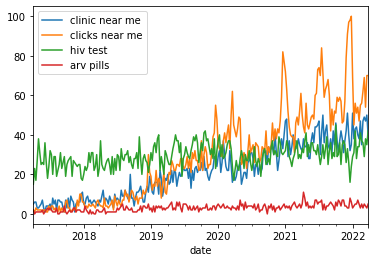

In [20]:
time_df.plot(legend=True)
plt.show()

##### Join datasets

In [21]:
### Add to overall stats table
geo_stats = geo_stats.merge(region_df, on='region')

## Save to file

In [22]:
geo_stats_df = geo_stats.drop('geometry', axis=1)
geo_stats_df.head()

region  facilities_private  facilities_public  total_facilities  \
0  Eastern Cape                   6                128               134   
1  Eastern Cape                  14                249               263   
2  Eastern Cape                  67                150               217   
3  Eastern Cape                  23                281               304   
4  Eastern Cape                   8                120               128   

   %_private  n_total  %_of_total_ever_private  %_segment_ever_private  \
0   0.044776   135.31                     0.65                    8.23   
1   0.053232    55.38                     0.39                   12.15   
2   0.308756   177.58                     2.03                   19.55   
3   0.075658   135.24                     0.54                    6.82   
4   0.062500    58.63                     0.20                    5.76   

   lower_ci  upper_ci  ...  hiv_result_positive  n_children_at_home_0.0  \
0      3.60     12.86  ...                21.95                   49.16   
1      3.55     20.76  ...                29.41                   64.05   
2     13.71     25.38  ...                12.23                   53.63   
3      2.57     11.07  ...                13.17                   53.67   
4      0.00     11.73  ...                22.00                   52.09   

   n_children_at_home_1.0  n_children_at_home_2.0  n_children_at_home_3.0  \
0                   22.21                   15.10                    7.61   
1                   17.81                   12.91                    2.80   
2                   20.11                   17.52                    7.27   
3                   18.55                   17.27                    8.79   
4                   23.59                   19.42                    1.75   

   n_children_at_home_4.0  clinic near me  clicks near me  hiv test  arv pills  
0                    3.27              21              33        42          4  
1                    2.42              21              33        42          4  
2                    1.07              21              33        42          4  
3                    1.15              21              33        42          4  
4                    3.15              21              33        42          4  

[5 rows x 109 columns]

In [23]:
geo_stats_df.to_excel(
    # root of data outputs
    output_data_path
    # specific subfolder
    + "Results/Tables/Final Summary Stats/"
    # filename
    "2.1 - enhanced_district_stats_with_facilities_gtrends.xlsx"
    )

## Draw Maps

### Facilities Maps

#### Get individual facilities coordinates

In [24]:
# drop facilities that don't have exact coordinates
facilities_df = facilities_df.dropna(subset=["coordinates_str"])

# convert coordinates from string to wkt geopandas-readable
facilities_df["coordinates"] = gpd.GeoSeries.from_wkt(facilities_df["coordinates_str"])
# convert to geopandas dataframe
gdf = gpd.GeoDataFrame(facilities_df, geometry="coordinates")

# ensure they are using the same projection
# gdf.crs = municipaities_shapes.crs

# Remove outliers (restrict to SA borders only)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
sa = world[world.name == "South Africa"]
xmin, ymin, xmax, ymax = sa.total_bounds
gdf = gdf.cx[xmin:xmax, ymin:ymax]

#### Plot facilities

In [25]:
cmap_custom = colors.LinearSegmentedColormap.from_list("", ["red", "blue"])

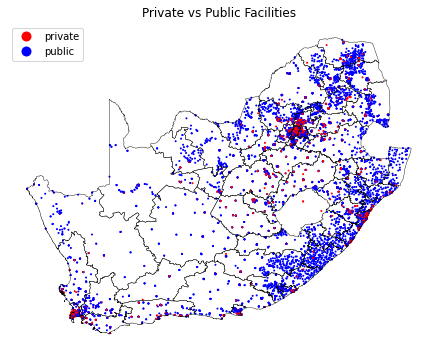

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shapes_df.boundary.plot(ax=ax, color="black", linewidth=0.4)
gdf.plot("ownership", markersize=1, cmap=cmap_custom, legend=True, ax=ax)
plt.title("Private vs Public Facilities")
plt.axis('off')
plt.show()

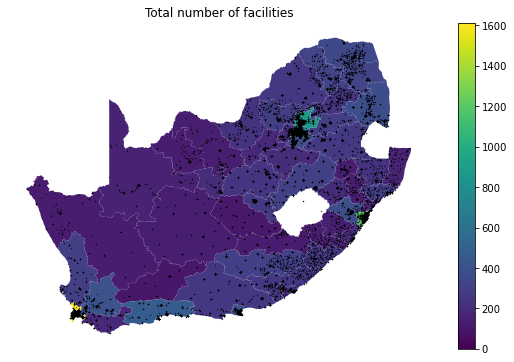

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
geo_stats.plot("total_facilities", cmap="viridis", vmin=0, legend=True, ax=ax)
gdf.plot(markersize=0.1, color="black", ax=ax)
plt.title("Total number of facilities")
plt.axis('off')
plt.show()

# density?

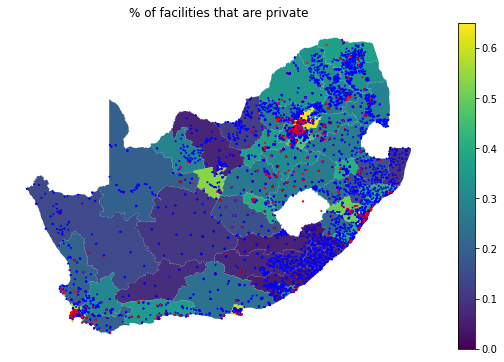

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
geo_stats.plot("%_private", cmap="viridis", vmin=0, legend=True, ax=ax)
gdf.plot("ownership", markersize=1, cmap=cmap_custom, ax=ax)
plt.title("% of facilities that are private")
plt.axis('off')
plt.show()

### DHS Maps

In [29]:
geo_stats['N_below_100'] = (geo_stats['n_total'] < 100)

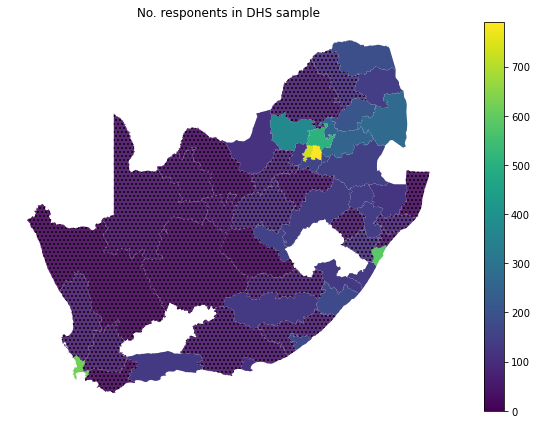

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
geo_stats.plot('n_total', cmap='viridis', vmin=0, legend=True, ax=ax)
geo_stats[geo_stats['N_below_100']].plot(color='white', hatch='...', alpha=0.1, ax=ax)
plt.title('No. responents in DHS sample')

plt.axis('off')
plt.tight_layout()
plt.savefig(output_data_path+'Results/Figures/Maps/min_100_N_districts.png',dpi=300)
plt.show()

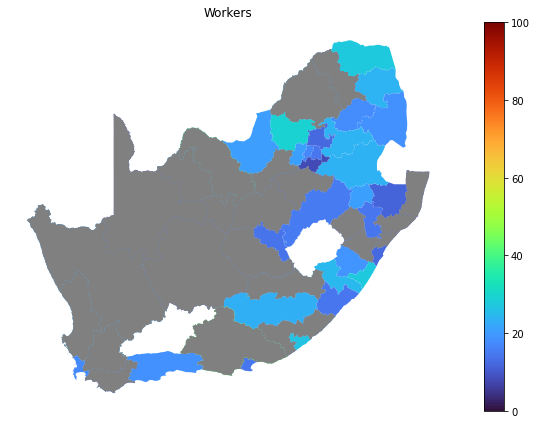

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
geo_stats.plot(
    "Workers", 
    cmap="turbo", 
    vmin=0, 
    vmax=100, 
    legend=True, 
    ax=ax
)
geo_stats[geo_stats["N_below_100"]].plot(color="grey", ax=ax)
plt.title("Workers")

plt.axis('off')
plt.tight_layout()
plt.savefig(output_data_path+'Results/Figures/Maps/workers_in_districts.png',dpi=300)
plt.show()

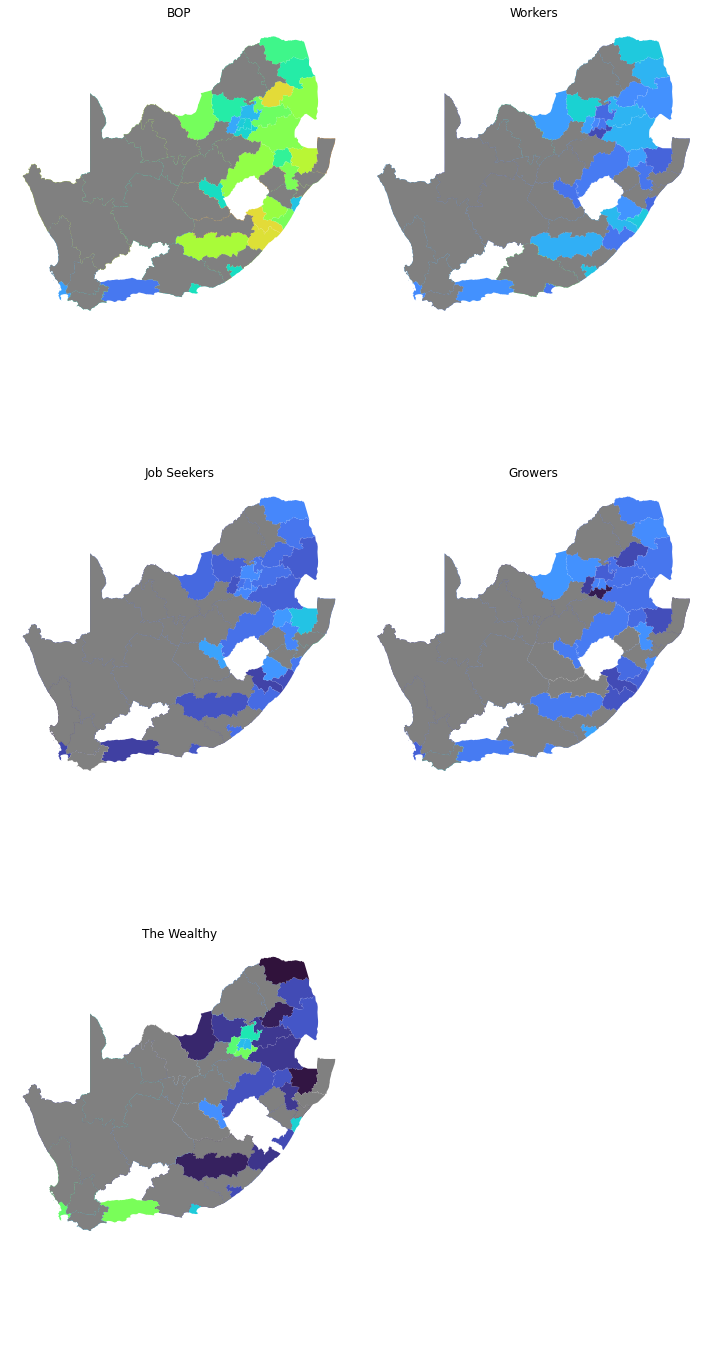

In [32]:
fig, axes = plt.subplots(
    3,2,
    sharex=True, sharey=True,
    figsize=(10,20)
    )

axes = axes.flatten()
for i,name in enumerate(segment_names):
    ax = axes[i]
    ax.set_axis_off()

    geo_stats.plot(name, cmap='turbo', vmin=0, vmax=100, ax=ax)
    # geo_stats[geo_stats['N_below_100']].plot(color='None', hatch='///', alpha=0.05, ax=ax)
    geo_stats[geo_stats['N_below_100']].plot(color='grey', ax=ax)

    ax.set_title(name)

axes[5].set_axis_off()
plt.tight_layout()
plt.savefig(output_data_path+'Results/Figures/Maps/segment_distributions.png', dpi=300)
plt.show()

In [33]:
geo_stats[segment_names].max()

BOP            70.36
Workers        40.80
Job Seekers    34.61
Growers        27.13
The Wealthy    45.13
dtype: float64

### Google Trends Maps

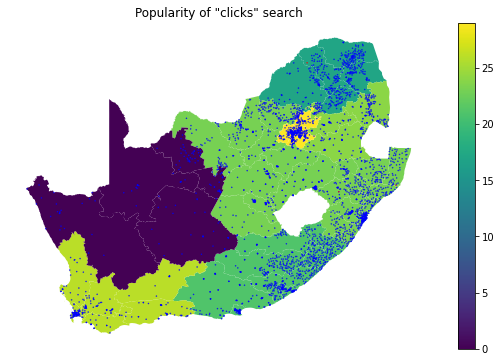

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
# plot search popularity
geo_stats.plot('clinic near me', cmap='viridis', vmin=0, legend=True, ax=ax)
# plot only clinics
gdf[gdf['facility_type']=='Clinic'].plot('ownership', markersize=0.2, cmap=cmap_custom, ax=ax)

plt.title('Popularity of \"clicks\" search')
plt.axis('off')
plt.show()

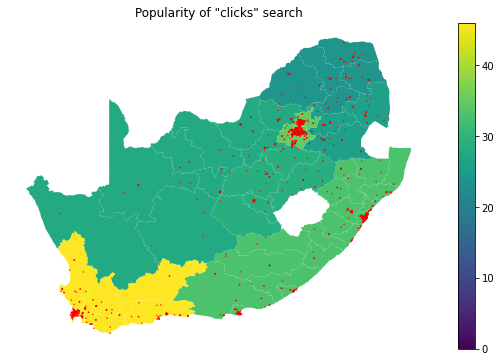

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
# plot search popularity
geo_stats.plot('clicks near me', cmap='viridis', vmin=0, legend=True, ax=ax)
# plot only pharmacies
gdf[gdf['facility_type']=='Pharmacy'].plot('ownership', markersize=0.2, cmap=cmap_custom, ax=ax)

plt.title('Popularity of \"clicks\" search')
plt.axis('off')
plt.show()

## Extras

### Match district names between UN and SA facilities datasets

In [36]:
# ### Export "UN district" and "SA facilities district" name matching

# # import manually matched facilities and
# district_names_UN_and_SA_facilities_index_matched = pd.read_csv(
#     output_data_path
#     + "District Name Matching/"
#     + "district_names_UN_and_SA_facilities_index_matched.csv",
# )

# district_names_UN = pd.read_csv(
#     output_data_path 
#     + "District Name Matching/" 
#     + "district_names_UN.csv"
# )

# # join on indices
# district_names_df = pd.merge(
#     district_names_UN_and_SA_facilities_index_matched,
#     district_names_UN,
#     on="UN_district_index",
#     how="outer",
# )

# # Central Karoo is missing from UN district names
# district_names_df.loc[
#     district_names_df["SA_facilities_district_name"] == "Central Karoo DM",
#     "UN_district_name",
# ] = "Central Karoo"

# district_names_df = district_names_df[
#     [
#         "SA_facilities_district_index",
#         "UN_district_index",
#         "SA_facilities_district_name",
#         "UN_district_name",
#         "details",
#     ]
# ]

# district_names_df.to_csv(output_data_path + "District Name Matching/" + "district_names_matched_UN_and_SA_facilities.csv")